In [1]:
import itertools
from random import random, randrange, choice
import math

In [2]:
class Ant(object):
    def __init__(self, id_, row, column, memory_size, has_trash):
        self.id_ = id_
        self.row = row
        self.column = column
        self.memory_size = memory_size
        self.has_trash = has_trash
        self.memories = [0] * self.memory_size
        
    def update_position(self, new_row, new_column):
        self.column = new_column
        self.row = new_row
        
    def count_memories(self):
        return self.memories.count(1)
    
    def add_memory(self, value):
        self.memories.pop()
        self.memories.insert(0, value)

In [3]:
def check_possible_moves(ocean, ant_map, row, column, vision_range=1):
    left_row = row
    if -1 < row - vision_range < len(ocean.index):
        left_row = row - vision_range
    
    right_row = row
    if -1 < row + vision_range < len(ocean.index):
        right_row = row + vision_range
    
    left_column = column
    if -1 < column - vision_range < len(ocean.columns):
        left_column = column - vision_range
        
    right_column = column
    if -1 < column + vision_range < len(ocean.columns):
        right_column = column + vision_range
    
    ant_vision = ant_map.loc[left_row:right_row, left_column:right_column]

    moves_row = ant_vision.index.tolist()
    moves_column = ant_vision.columns.tolist()
    
    possible_moves = [[r,c] for r in moves_row for c in moves_column if ant_map.at[r, c] == 0 and [r, c] != [row, column]]
    
    return possible_moves

In [4]:
"""def drop_probability(ant, drop_constant):
    fx = ant.count_memories() / ant.memory_size
    return (fx / drop_constant + fx)**2""";

In [5]:
"""def pick_probability(ant, pick_constant):
    fx = ant.count_memories() / ant.memory_size
    return (pick_constant / pick_constant + fx)**2""";

In [6]:
def calculate_f(alpha, ant_row, ant_column, ocean, drop=False):
    s = 0
    summation = 0
    
    row1 = 0 if ant_row - 1 < 0 else ant_row - 1
    row2 = len(ocean.index) if ant_row + 1 > len(ocean.columns) else ant_row + 1
    
    column1 = 0 if ant_column - 1 < 0 else ant_column - 1
    column2 = len(ocean.columns) if ant_column + 1 > len(ocean.columns) else ant_column + 1
    
    for r in range(row1, row2):
        for c in range(column1, column2):
            if [r, c] != [ant_row, ant_column]:
                s += 1
                if ocean.at[r, c] == 1:
                    a = (r, c)
                    b = (ant_row, ant_column)
                    
                    distance = math.sqrt(sum([(row - column)**2 for row, column in zip(a, b)]))
                    summation += (1 - distance/alpha)
    
    try:
        fi = summation/s
    except ZeroDivisionError:
        fi = 0
    
    fi = 0 if fi <= 0 else fi
    
    return fi

In [7]:
def move_ants(ocean, ants, ant_map, drop_constant, pick_constant, alpha):
    random_value = random()
    
    for ant in ants:
        possible_moves = check_possible_moves(ocean, ant_map, ant.row, ant.column)
        
        if len(possible_moves) > 0:
            ant_map.at[ant.row, ant.column] = 0
            
            move = choice(possible_moves)

            ant_map.at[move[0], move[1]] = 1
            ant.row = move[0]
            ant.column = move[1]
            
            if ocean.at[move[0], move[1]] == 1 and ant.has_trash == 0:
                fi = calculate_f(alpha, move[0], move[1], ocean)
                pick_value = (pick_constant / (pick_constant + fi))**2
                if random_value < pick_value:
                    #print(f"Ant {ant.id_} had nothing and took trash!")
                    ocean.at[move[0], move[1]] = 0
                    ant.has_trash = 1
                ant.add_memory(1)
                # print(f"Ant {ant.id_} had nothing and found trash!")
            elif ocean.at[move[0], move[1]] == 1 and ant.has_trash == 1:
                ant.add_memory(1)
                # print(f"Ant {ant.id_} had trash and found trash!")
            elif ocean.at[move[0], move[1]] == 0 and ant.has_trash == 1:
                fi = calculate_f(alpha, move[0], move[1], ocean,True)
                drop_value = 2 * fi if fi < drop_constant else 1
                #print(f"Ant {ant.id_} had trash and did not find anything!")
                if random_value < drop_value:
                    #print(f"Ant {ant.id_} had trash and dropped it!")
                    ocean.at[move[0], move[1]] = 1
                    ant.has_trash = 0
                ant.add_memory(0)
                # print(f"Ant {ant.id_} had trash and did not find anything!")
            elif ocean.at[move[0], move[1]] == 0 and ant.has_trash == 0:
                ant.add_memory(0)
                # print(f"Ant {ant.id_} did not have trash and did not find anything!")
                
    return ocean, ants

**DISEÑAR ALGORITMO CON UNA HORMIGA PARA VER SU COMPORTAMIENTO Y EFICIENCIA**

Una hormiga comprobará todas las posiciones visitables del mapa, y si dichas posiciones están o no en su memoria, que en caso de estarlo y no ser un punto de recogida no se visitarán. Pero si por el contrario, la hormiga tiene basura y ha depositado basura en una posición aún en su memoria, retrocederá hasta dicha concentración de basura para soltarla, sino buscará una posible ubicación aleatoria. Sino, por defecto, la hormiga sigue un recorrido aleatorio tenga o no basura y/o información del destino.

In [8]:
import pickle

In [9]:
with open('test_data.pickle', 'rb') as data:
    ocean = pickle.load(data)

In [10]:
trash_counter = 0

for row in range(len(ocean.index)):
    for column in range(len(ocean.columns)):
        if ocean.at[row, column] == 1:
            trash_counter+= 1

In [11]:
trash_counter

2011

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

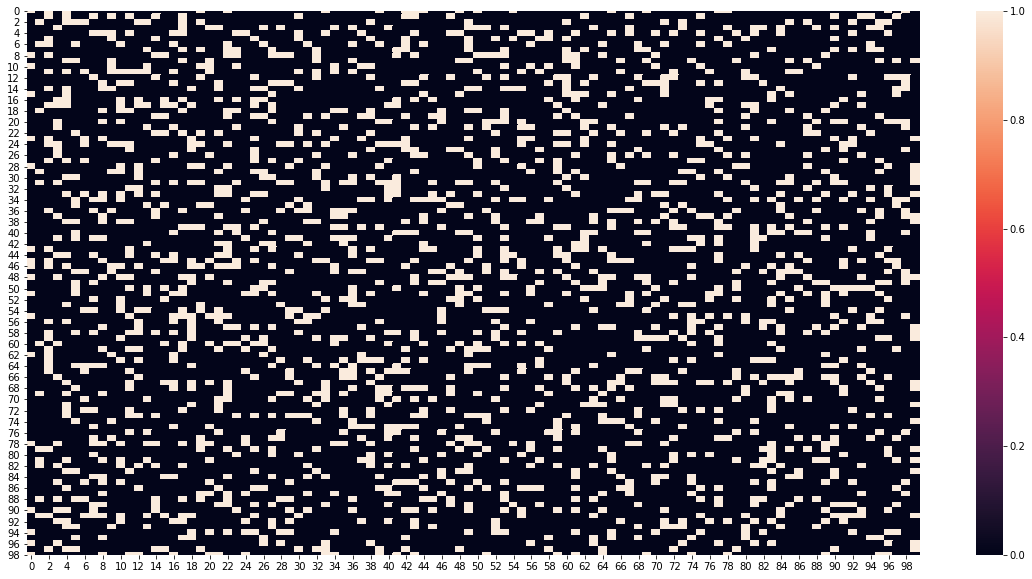

In [13]:
plt.figure(figsize=(20,10))
sns.heatmap(ocean)

In [14]:
import pandas as pd

In [15]:
data = [[0 for x in range(len(ocean))] for y in range(len(ocean))]
ant_map = pd.DataFrame(data)

In [16]:
ants = list()

total_ants = 200
memory_size = 15

In [17]:
for ant in range(1, total_ants + 1):
    flag = False
    
    while flag is False:
        row = randrange(len(ocean.index))
        column = randrange(len(ocean.columns))

        if ant_map.at[row, column] == 1:
            pass
        
        if ocean.at[row, column] == 1:
            ants.append(Ant(id_=ant, row=row, column=column, memory_size=memory_size, has_trash=1))
            ant_map.at[row, column] = 1
            flag = True
        elif ocean.at[row, column] == 0:
            ants.append(Ant(id_=ant, row=row, column=column, memory_size=memory_size, has_trash=0))
            ant_map.at[row, column] = 1
            flag = True

In [18]:
%%time

steps = 1000
drop_constant = .15
pick_constant = .1
alpha = 2.1

while steps > 0:
    ocean, ants = move_ants(ocean, ants, ant_map, drop_constant, pick_constant, alpha)
    #print("step: " + str(steps))
    steps -= 1

Wall time: 1min


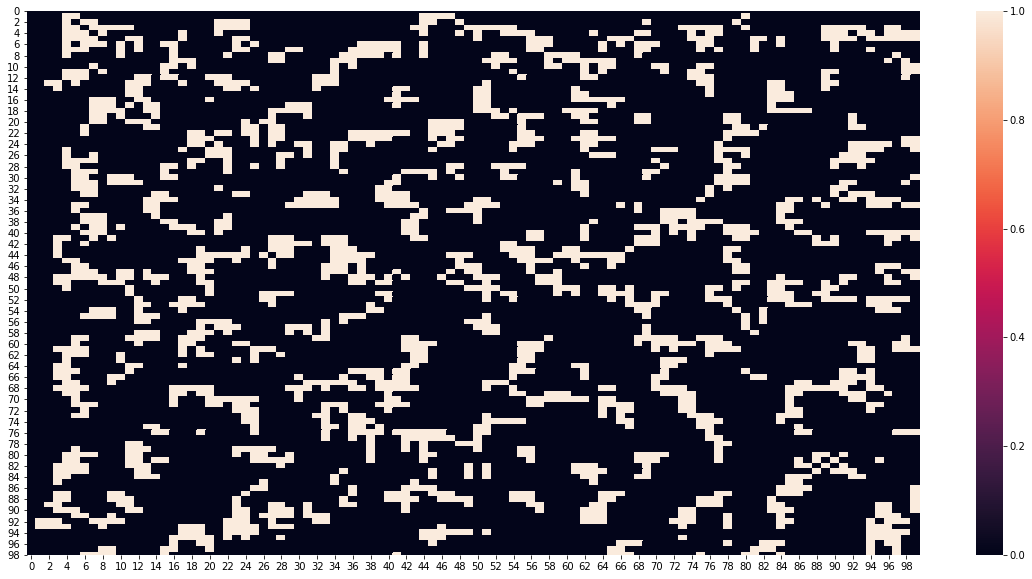

In [19]:
plt.figure(figsize=(20,10))
sns.heatmap(ocean)

In [20]:
trash_counter = 0

for row in range(len(ocean.index)):
    for column in range(len(ocean.columns)):
        if ocean.at[row, column] == 1:
            trash_counter+= 1

In [21]:
trash_counter

2000

In [22]:
trash_counter = 0

for row in range(len(ant_map.index)):
    for column in range(len(ant_map.columns)):
        if ant_map.at[row, column] == 1:
            trash_counter+= 1

In [23]:
trash_counter

200

In [24]:
ant_map

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
96,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
97,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
98,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
